In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns 
import re
 
import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
import sklearn

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, scale, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.inspection import permutation_importance

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic
from sklearn.gaussian_process.kernels import Kernel, Hyperparameter, ConstantKernel
from sklearn.gaussian_process.kernels import GenericKernelMixin

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score  

from sklearn.pipeline import make_pipeline

from sklearn.base import clone

In [3]:
def run_models():
    rf = RandomForestRegressor(n_estimators= 100, random_state= 10)
    gb = GradientBoostingRegressor(loss='quantile', alpha=0.5,
                                n_estimators=100, max_depth=10,
                                learning_rate=0.25, min_samples_leaf=9,
                                min_samples_split=2)
    lr = LinearRegression()
    rr = Ridge(alpha=0.01)
    lasso = Lasso(alpha=0.01)
    gpr1 = GaussianProcessRegressor(kernel=DotProduct() + WhiteKernel(),random_state=0)
    gpr2 = GaussianProcessRegressor(kernel=1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3))+ 
                                WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1)),alpha=0.0)
    gpr3 = GaussianProcessRegressor(kernel=ConstantKernel(1.0, (1e-2, 1e3)) * RBF(10, (1e-3, 1e4)),
                                n_restarts_optimizer=9)
    gpr4 = GaussianProcessRegressor(kernel=1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)))
    gpr5 = GaussianProcessRegressor(kernel=1.0 * RationalQuadratic(length_scale=1.0, alpha=0.01))
    gpr6 = GaussianProcessRegressor(kernel=1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 10.0),nu=0.35))
    models = [rf,gb,lr,rr,lasso,gpr1,gpr2,gpr3,gpr4,gpr5,gpr6]
    models_names = ["RF","GB","LR","RR","LASSO","gpr1","gpr2","gpr3","gpr4","gpr5","gpr6"]
    r2scores=[]
    rmse=[]
    count=0
    for model in models :
        predicted_y = []
        expected_y = []
        kf = KFold(n_splits= 10) 
        # partition data
        for train_index, test_index in kf.split(X, Y):
            # specific ".loc" syntax for working with dataframes
            x_train, x_test = X.loc[train_index], X.loc[test_index]
            y_train, y_test = Y[train_index], Y[test_index]

            # create and fit classifier
            model.fit(x_train, y_train)

            # store result from classification
            predicted_y.extend(model.predict(x_test))

            # store expected result for this specific fold
            expected_y.extend(y_test)
        
        r2 = metrics.r2_score(expected_y, predicted_y)
        r2scores.append(r2)
        
        err=np.sqrt(metrics.mean_squared_error(expected_y, predicted_y))
        rmse.append(err)
        
        print(models_names[count])
        print("R2: ",r2.__str__())
        print("RMSE: ",err)
        print("---------------------------------------")
        count+=1
    
    plt.rcdefaults()
    fig, ax = plt.subplots()

    x_pos = np.arange(len(models_names))
    ax.bar(x_pos, r2scores, align='center')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models_names)
    ax.set_ylabel('R2 Score')
    #plt.savefig('imp.eps', format='eps')
    #plt.show()
    print(r2scores)

# Standard Scaling

In [4]:
data_std = pd.read_csv('scaled_standard_Coeff_B.csv', encoding='cp1252')   

In [5]:
data_std.columns.values

array(['Name', 'density', 'mean_A2B', 'mean_A2X', 'mean_B2X', 'mean_X2X',
       'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh', 'TF', 'OF',
       'A_Z', 'B_Z', 'X_Z', 'A_G', 'B_G', 'X_G', 'A_IEI', 'B_IEI',
       'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII', 'A_EA', 'B_EA', 'X_EA',
       'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA', 'B_ChiA', 'A_Rvdw',
       'B_Rvdw', 'X_Rvdw', 'B_Rc', 'B_Ra', 'A_MP', 'B_MP', 'A_Rho',
       'B_Rho', 'X_Rho', 'B_MV', 'X_MV', 'B_Hf', 'A_Kappa', 'B_Kappa',
       'X_Kappa', 'A_CvM', 'B_CvM', 'A_B', 'B_B', 'B_MendeleevNo',
       'Coeff_B'], dtype=object)

In [6]:
data_std.fillna(0, inplace= True)

In [7]:
Y = data_std['Coeff_B'] 
X = data_std.drop(['Coeff_B','Name'], axis=1)

### Using CV technique

RF
R2:  0.9040453154443587
RMSE:  0.3097655315809705
---------------------------------------
GB
R2:  0.8445987140439155
RMSE:  0.3942096979477857
---------------------------------------
LR
R2:  -5.580204438660056
RMSE:  2.565190916610313
---------------------------------------
RR
R2:  -0.46745016571684994
RMSE:  1.2113835749740254
---------------------------------------
LASSO
R2:  0.8888182400511636
RMSE:  0.333439289749778
---------------------------------------
gpr1
R2:  0.4689857341936998
RMSE:  0.7287072565895719
---------------------------------------
gpr2
R2:  0.9390411008409811
RMSE:  0.24689856046364245
---------------------------------------
gpr3
R2:  0.9432185995920211
RMSE:  0.23828848148405918
---------------------------------------
gpr4
R2:  0.9432185991565915
RMSE:  0.23828848239772002
---------------------------------------
gpr5
R2:  0.9434956302262537
RMSE:  0.23770647819053298
---------------------------------------
gpr6
R2:  0.8705185354579944
RMSE:  0.359835329757940

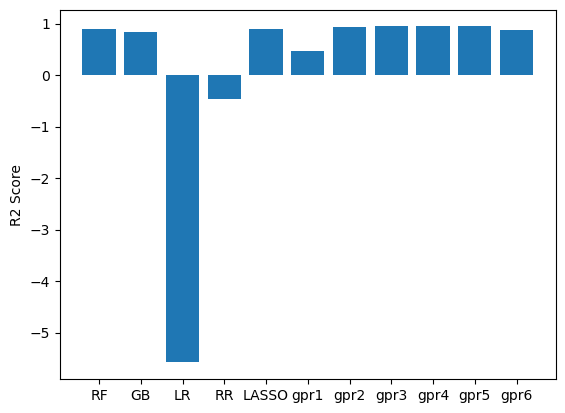

In [8]:
run_models()

## Feature selection


In [9]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature       Score
1   mean_A2B  123.813866
26      X_EA  117.183506
14       X_Z   99.651797
34    X_Rvdw   87.228516
4   mean_X2X   73.889589
23    X_IEII   71.960813
32    A_Rvdw   51.441835
2   mean_A2X   50.449602
18     A_IEI   35.525431
30    A_ChiA   32.735412
9      E_coh   31.896431
44      B_Hf   19.545691
17       X_G   17.821495
6    std_A2X   16.320932
27    A_ChiP   15.809368
38      B_MP   15.701586
7    std_B2X   15.556831
11        OF   15.234473
36      B_Ra   14.704776
37      A_MP   12.747613
24      A_EA   11.971525
13       B_Z   11.111687
12       A_Z   11.021670
47   X_Kappa    8.465232
48     A_CvM    8.222969
45   A_Kappa    7.662938
42      B_MV    7.438268
43      X_MV    7.201300
46   B_Kappa    6.859575
5    std_A2B    5.573858


In [10]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 'X_Z', 'X_Rvdw', 'mean_X2X', 'X_IEII',
       'A_Rvdw', 'mean_A2X', 'A_IEI', 'A_ChiA', 'E_coh', 'B_Hf', 'X_G',
       'std_A2X', 'A_ChiP', 'B_MP', 'std_B2X', 'OF', 'B_Ra', 'A_MP',
       'A_EA', 'B_Z', 'A_Z', 'X_Kappa', 'A_CvM', 'A_Kappa', 'B_MV',
       'X_MV', 'B_Kappa', 'std_A2B', 'A_B', 'B_CvM', 'B_Rho', 'std_X2X',
       'A_G', 'TF', 'B_EA', 'B_Rvdw', 'X_IEI', 'B_Rc'], dtype=object)

In [11]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]

RF
R2:  0.9069796711940419
RMSE:  0.3049923422087154
---------------------------------------
GB
R2:  0.8330061316132444
RMSE:  0.40864883260172846
---------------------------------------
LR
R2:  -2.1698120503407248
RMSE:  1.7803965991712984
---------------------------------------
RR
R2:  0.2733691734384124
RMSE:  0.8524264346919256
---------------------------------------
LASSO
R2:  0.8996086482539054
RMSE:  0.31684594323755294
---------------------------------------
gpr1
R2:  0.7263399531932688
RMSE:  0.5231252687518843
---------------------------------------
gpr2
R2:  0.9489249642848782
RMSE:  0.22599786661630641
---------------------------------------
gpr3
R2:  0.9510524726772582
RMSE:  0.2212408807674154
---------------------------------------
gpr4
R2:  0.9510524725832195
RMSE:  0.22124088097994135
---------------------------------------
gpr5
R2:  0.9515369472321833
RMSE:  0.22014325510407243
---------------------------------------
gpr6
R2:  0.8948288985948674
RMSE:  0.3243009426522

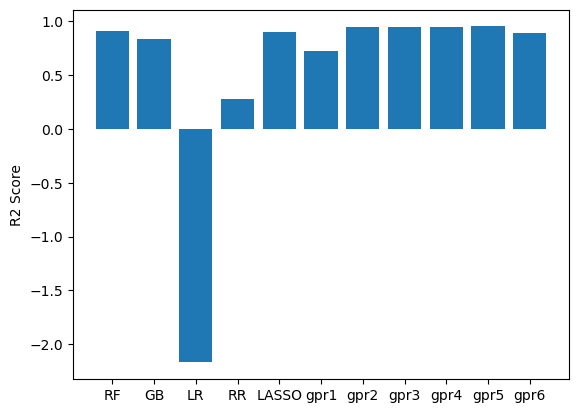

In [12]:
run_models()

In [13]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 'X_Z', 'X_Rvdw', 'mean_X2X', 'X_IEII',
       'A_Rvdw', 'mean_A2X', 'A_IEI', 'A_ChiA', 'E_coh', 'B_Hf', 'X_G',
       'std_A2X', 'A_ChiP', 'B_MP', 'std_B2X', 'OF', 'B_Ra', 'A_MP',
       'A_EA', 'B_Z', 'A_Z', 'X_Kappa', 'A_CvM', 'A_Kappa', 'B_MV',
       'X_MV', 'B_Kappa', 'std_A2B'], dtype=object)

In [14]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]

RF
R2:  0.8998491982470521
RMSE:  0.3164661146994222
---------------------------------------
GB
R2:  0.8466702061455559
RMSE:  0.39157348461616254
---------------------------------------
LR
R2:  0.6553256314604707
RMSE:  0.5870897448768198
---------------------------------------
RR
R2:  0.6653386016424313
RMSE:  0.5784992639213715
---------------------------------------
LASSO
R2:  0.8937370786143087
RMSE:  0.32597994015842635
---------------------------------------
gpr1
R2:  0.7313984050981863
RMSE:  0.5182678794810784
---------------------------------------
gpr2
R2:  0.9282475435083468
RMSE:  0.26786649004989993
---------------------------------------
gpr3
R2:  0.9400037403584771
RMSE:  0.24494133918455435
---------------------------------------
gpr4
R2:  0.9400037419744399
RMSE:  0.2449413358858812
---------------------------------------
gpr5
R2:  0.9408357060274536
RMSE:  0.24323711471020706
---------------------------------------
gpr6
R2:  0.906240723367562
RMSE:  0.306201366150508

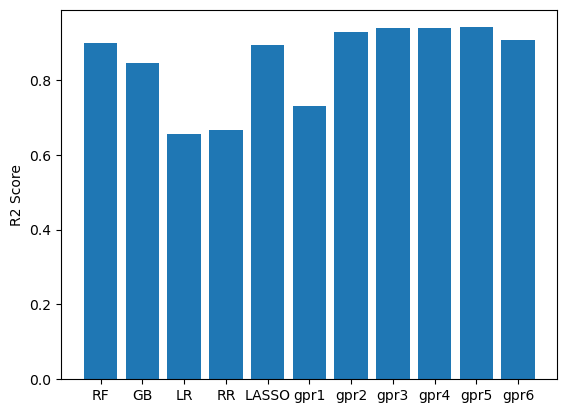

In [15]:
run_models()

In [16]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 'X_Z', 'X_Rvdw', 'mean_X2X', 'X_IEII',
       'A_Rvdw', 'mean_A2X', 'A_IEI', 'A_ChiA', 'E_coh', 'B_Hf', 'X_G',
       'std_A2X', 'A_ChiP', 'B_MP', 'std_B2X', 'OF', 'B_Ra', 'A_MP'],
      dtype=object)

In [17]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]

RF
R2:  0.8777658713890886
RMSE:  0.34961997741964257
---------------------------------------
GB
R2:  0.8086772351357466
RMSE:  0.43740457801016824
---------------------------------------
LR
R2:  0.8195185093395743
RMSE:  0.42483113193412014
---------------------------------------
RR
R2:  0.8200369448059193
RMSE:  0.4242205266062461
---------------------------------------
LASSO
R2:  0.881663378866629
RMSE:  0.3440009028089476
---------------------------------------
gpr1
R2:  0.8555004061247118
RMSE:  0.38013102198490484
---------------------------------------
gpr2
R2:  0.9229382155928397
RMSE:  0.2776000439610201
---------------------------------------
gpr3
R2:  0.8040970336002515
RMSE:  0.44260927057592064
---------------------------------------
gpr4
R2:  0.9151224151856353
RMSE:  0.29133757878853295
---------------------------------------
gpr5
R2:  0.9306881793136887
RMSE:  0.2632713822015435
---------------------------------------
gpr6
R2:  0.9237637788625572
RMSE:  0.27610907471041

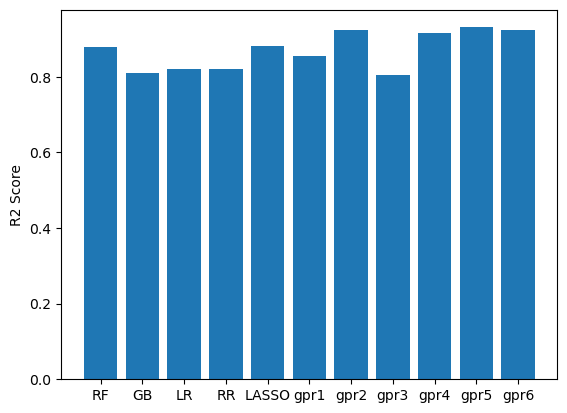

In [18]:
run_models()

In [19]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 'X_Z', 'X_Rvdw', 'mean_X2X', 'X_IEII',
       'A_Rvdw', 'mean_A2X', 'A_IEI', 'A_ChiA'], dtype=object)

In [20]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]

RF
R2:  0.8572433568993887
RMSE:  0.3778315009374037
---------------------------------------
GB
R2:  0.801612542256012
RMSE:  0.4454070697058905
---------------------------------------
LR
R2:  0.8517160365954504
RMSE:  0.38507656823617503
---------------------------------------
RR
R2:  0.851761369307936
RMSE:  0.3850177017905332
---------------------------------------
LASSO
R2:  0.8547612035465528
RMSE:  0.38110208140791774
---------------------------------------
gpr1
R2:  0.8623884958253317
RMSE:  0.3709602460839547
---------------------------------------
gpr2
R2:  0.8571258108858765
RMSE:  0.37798702241495474
---------------------------------------
gpr3
R2:  0.44485110304728914
RMSE:  0.7450831476772984
---------------------------------------
gpr4
R2:  0.4571322462618914
RMSE:  0.736795598343332
---------------------------------------
gpr5
R2:  0.8433540021996703
RMSE:  0.39578529255181993
---------------------------------------
gpr6
R2:  0.8532580829007448
RMSE:  0.38306907614587626

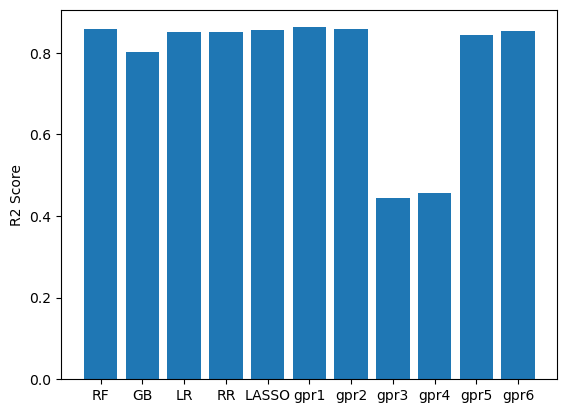

In [21]:
run_models()

# Min-Max scaling

In [22]:
data_mm = pd.read_csv('scaled_minmax_Coeff_B.csv', encoding='cp1252')

In [23]:
data_mm.fillna(0, inplace= True)

In [24]:
Y = data_mm['Coeff_B'] 
X = data_mm.drop(['Coeff_B','Name'], axis=1)

### Using CV technique

RF
R2:  0.9046890987335664
RMSE:  0.08340763738057017
---------------------------------------
GB
R2:  0.8597818674643691
RMSE:  0.10116647565500346
---------------------------------------
LR
R2:  -7.055989780300152
RMSE:  0.7668209766247539
---------------------------------------
RR
R2:  0.7504676687718039
RMSE:  0.13495778547949583
---------------------------------------
LASSO
R2:  0.8267494157499651
RMSE:  0.11245321732162042
---------------------------------------
gpr1
R2:  0.6335938001798578
RMSE:  0.16353696668737283
---------------------------------------
gpr2
R2:  0.9400514084006424
RMSE:  0.0661491127706708
---------------------------------------
gpr3
R2:  0.940709379949343
RMSE:  0.06578509821223873
---------------------------------------
gpr4
R2:  0.9407093828949686
RMSE:  0.06578509657809933
---------------------------------------
gpr5
R2:  0.9542901561745804
RMSE:  0.05776162465059937
---------------------------------------
gpr6
R2:  0.901597353514233
RMSE:  0.0847496514345

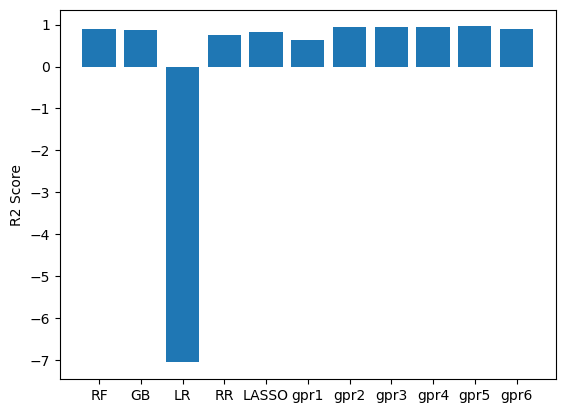

In [25]:
run_models()

## Feature selection


In [26]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature       Score
1   mean_A2B  123.813866
26      X_EA  117.183506
14       X_Z   99.651797
34    X_Rvdw   87.228516
4   mean_X2X   73.889589
32    A_Rvdw   51.441835
2   mean_A2X   50.449602
18     A_IEI   35.525431
9      E_coh   31.896431
30    A_ChiA   31.410595
44      B_Hf   19.545691
17       X_G   17.821495
6    std_A2X   16.320932
23    X_IEII   15.947207
27    A_ChiP   15.809368
38      B_MP   15.701586
7    std_B2X   15.556831
11        OF   15.234473
36      B_Ra   14.704776
37      A_MP   12.747613
24      A_EA   11.971525
13       B_Z   11.111687
12       A_Z   11.021670
41     X_Rho   10.709519
47   X_Kappa    8.465232
48     A_CvM    8.222969
31    B_ChiA    7.956686
45   A_Kappa    7.662938
42      B_MV    7.438268
43      X_MV    7.201300


In [27]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 'X_Z', 'X_Rvdw', 'mean_X2X', 'A_Rvdw',
       'mean_A2X', 'A_IEI', 'E_coh', 'A_ChiA', 'B_Hf', 'X_G', 'std_A2X',
       'X_IEII', 'A_ChiP', 'B_MP', 'std_B2X', 'OF', 'B_Ra', 'A_MP',
       'A_EA', 'B_Z', 'A_Z', 'X_Rho', 'X_Kappa', 'A_CvM', 'B_ChiA',
       'A_Kappa', 'B_MV', 'X_MV', 'B_Kappa', 'std_A2B', 'A_B', 'B_CvM',
       'std_X2X', 'A_G', 'B_Rho', 'TF', 'B_EA', 'B_Rvdw'], dtype=object)

In [28]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]

RF
R2:  0.9068889488197633
RMSE:  0.0824394614767302
---------------------------------------
GB
R2:  0.8343136058409388
RMSE:  0.10997094437244626
---------------------------------------
LR
R2:  -0.11916547670577438
RMSE:  0.2858128060381948
---------------------------------------
RR
R2:  0.8381158221701527
RMSE:  0.10870179940777458
---------------------------------------
LASSO
R2:  0.8267591204380129
RMSE:  0.11245006772566975
---------------------------------------
gpr1
R2:  0.7828903771425757
RMSE:  0.12588502421921335
---------------------------------------
gpr2
R2:  0.9399788187664813
RMSE:  0.06618914946780627
---------------------------------------
gpr3
R2:  0.9341862212524027
RMSE:  0.06930952855161004
---------------------------------------
gpr4
R2:  0.934186223129284
RMSE:  0.06930952756332338
---------------------------------------
gpr5
R2:  0.9482546437365745
RMSE:  0.061456839456776234
---------------------------------------
gpr6
R2:  0.9101585674901828
RMSE:  0.080979085

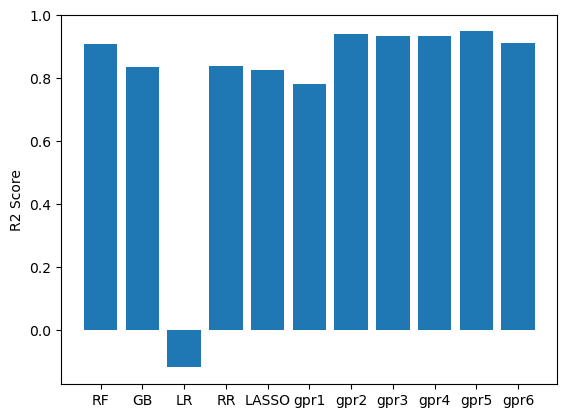

In [29]:
run_models()

In [30]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 'X_Z', 'X_Rvdw', 'mean_X2X', 'A_Rvdw',
       'mean_A2X', 'A_IEI', 'E_coh', 'A_ChiA', 'B_Hf', 'X_G', 'std_A2X',
       'X_IEII', 'A_ChiP', 'B_MP', 'std_B2X', 'OF', 'B_Ra', 'A_MP',
       'A_EA', 'B_Z', 'A_Z', 'X_Rho', 'X_Kappa', 'A_CvM', 'B_ChiA',
       'A_Kappa', 'B_MV', 'X_MV'], dtype=object)

In [31]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]

RF
R2:  0.8964288422858656
RMSE:  0.08694686885278366
---------------------------------------
GB
R2:  0.8369491926668786
RMSE:  0.10909277977641023
---------------------------------------
LR
R2:  0.7622540827258542
RMSE:  0.1317319331743408
---------------------------------------
RR
R2:  0.8319806842670687
RMSE:  0.11074245250284948
---------------------------------------
LASSO
R2:  0.8267591091412199
RMSE:  0.11245007139202472
---------------------------------------
gpr1
R2:  0.8402390867153269
RMSE:  0.10798658287790433
---------------------------------------
gpr2
R2:  0.9229082651280768
RMSE:  0.07501332926705917
---------------------------------------
gpr3
R2:  0.911224569808235
RMSE:  0.08049722777781108
---------------------------------------
gpr4
R2:  0.9112245616999702
RMSE:  0.08049723145390039
---------------------------------------
gpr5
R2:  0.9372227854876503
RMSE:  0.06769172043947899
---------------------------------------
gpr6
R2:  0.9193155061400643
RMSE:  0.07674137402

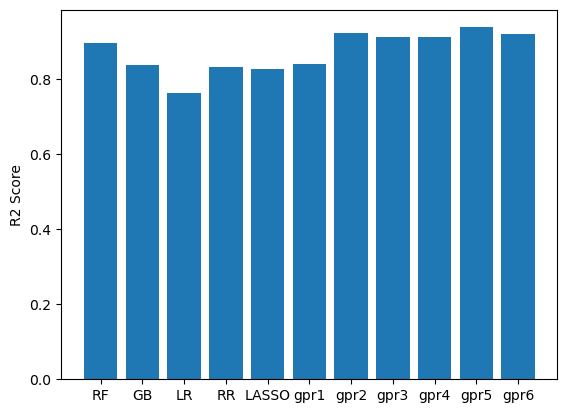

In [32]:
run_models()

In [33]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 'X_Z', 'X_Rvdw', 'mean_X2X', 'A_Rvdw',
       'mean_A2X', 'A_IEI', 'E_coh', 'A_ChiA', 'B_Hf', 'X_G', 'std_A2X',
       'X_IEII', 'A_ChiP', 'B_MP', 'std_B2X', 'OF', 'B_Ra', 'A_MP'],
      dtype=object)

In [34]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]

RF
R2:  0.8866632195122127
RMSE:  0.09095361544868656
---------------------------------------
GB
R2:  0.790936812108644
RMSE:  0.12353024863377672
---------------------------------------
LR
R2:  0.8337931482062833
RMSE:  0.11014353048373748
---------------------------------------
RR
R2:  0.8546178034861199
RMSE:  0.10301255152859673
---------------------------------------
LASSO
R2:  0.8108589802780296
RMSE:  0.1174971667366398
---------------------------------------
gpr1
R2:  0.8565726718164348
RMSE:  0.10231763318512019
---------------------------------------
gpr2
R2:  0.9174921459787427
RMSE:  0.07760365514629254
---------------------------------------
gpr3
R2:  0.8528809146632059
RMSE:  0.10362607273862162
---------------------------------------
gpr4
R2:  0.8528809034552292
RMSE:  0.10362607668589532
---------------------------------------
gpr5
R2:  0.9254192068511937
RMSE:  0.07378159341154529
---------------------------------------
gpr6
R2:  0.9292251839525596
RMSE:  0.07187434599

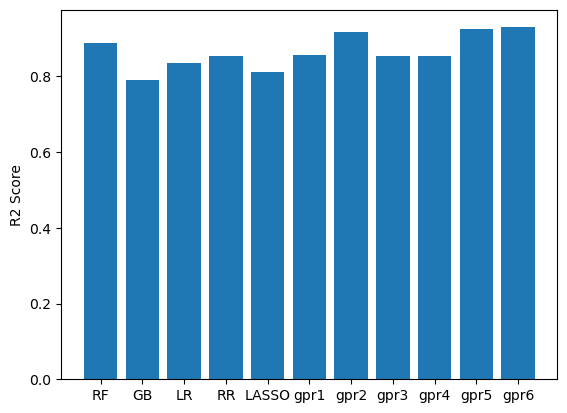

In [35]:
run_models()

In [36]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 'X_Z', 'X_Rvdw', 'mean_X2X', 'A_Rvdw',
       'mean_A2X', 'A_IEI', 'E_coh', 'A_ChiA'], dtype=object)

In [37]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]

RF
R2:  0.8945498579750752
RMSE:  0.087732017347502
---------------------------------------
GB
R2:  0.7649907142760421
RMSE:  0.13097157271645204
---------------------------------------
LR
R2:  0.8241938723203222
RMSE:  0.11327955529858266
---------------------------------------
RR
R2:  0.8289892107435505
RMSE:  0.11172395134481314
---------------------------------------
LASSO
R2:  0.8031867917687119
RMSE:  0.11985651663114033
---------------------------------------
gpr1
R2:  0.8301547603994477
RMSE:  0.11134256471959061
---------------------------------------
gpr2
R2:  0.8492050174007728
RMSE:  0.10491267899179486
---------------------------------------
gpr3
R2:  0.5295579455240402
RMSE:  0.18530519731371822
---------------------------------------
gpr4
R2:  0.5295579799152645
RMSE:  0.18530519054043695
---------------------------------------
gpr5
R2:  0.8734872065266155
RMSE:  0.09609521305016243
---------------------------------------
gpr6
R2:  0.8721522128459926
RMSE:  0.09660089253

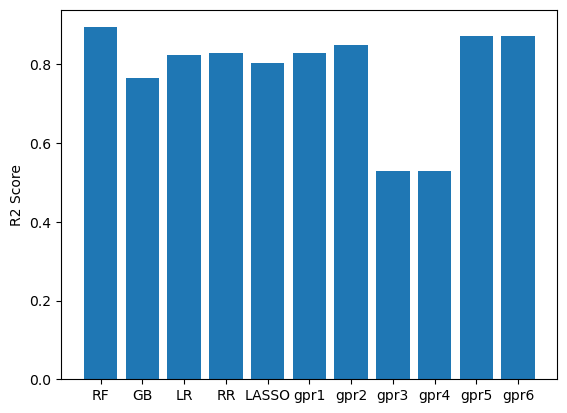

In [38]:
run_models()